In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import tqdm

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d
from models import RobustSimilitude, Similitude2

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
dtype=torch.float32
models = []
ncells_to_include = [3,5,7,100]
for ncells in ncells_to_include:
    ci_model = RobustSimilitude(ncells=ncells,dtype=dtype,rectify=False,
                                dropout=False,lr=1e-3,p_magnitude=0,r_magnitude=1e-1) 
    robust_ci_model = RobustSimilitude(ncells=ncells,dtype=dtype,rectify=False,
                                       dropout=False,lr=1e-3,p_magnitude=1e-1,r_magnitude=1e-1)
    jacobian_model = Similitude2(ncells=ncells, dtype=dtype, rectify=False)
    models.append(ci_model)
    models.append(robust_ci_model)
    models.append(jacobian_model)

for model in models:
    model.set_phases(torch.normal(torch.zeros((model.ncells,2))+0.2,0.01))

In [5]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    Gs = []
    phases_history = [model.phases.clone().detach().numpy()]
    for epoch in tqdm.trange(4000):
        if epoch == 3500:
            model.p_magnitude=0
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        G = np.mean(model.metric_tensor(model.jacobian(rs)).detach().numpy(),axis=0)
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        Gs.append(G)
    Gs = np.array(Gs)
    return loss_history, Gs, phases_history

In [6]:
loss_histories, Gss, phases_histories = [],[],[]
for model in models:
    loss_history, Gs, phases_history = train_model(model)
    loss_histories.append(loss_history)
    Gss.append(Gs)
    phases_histories.append(phases_history)
loss_histories = np.array(loss_histories)
Gss = np.array(Gss)

100%|██████████████████████████████████████| 4000/4000 [00:23<00:00, 170.27it/s]


In [35]:
width_ratio_hexagons = (np.linalg.norm(model.unit_cell.basis[0])*4) / (np.linalg.norm(model.unit_cell.hpoints[0])*5)
width_ratio_hexagons

0.6928203230275509

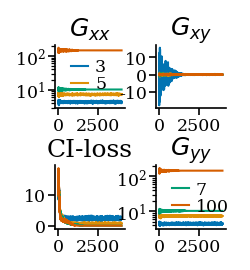

In [57]:
figsize=set_size(fraction=(1-width_ratio_hexagons,1/3),mode='square')
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=figsize)
axs[0,0].semilogy(Gss[::3,:,0,0].T)
axs[0,0].set_title('$G_{xx}$')
axs[0,0].legend(ncells_to_include[:2])#,labelspacing=0,handlelength=1,handletextpad=0.4)
axs[0,1].plot(Gss[::-3,:,1,0].T)#,alpha=.7) # reverse order to plot s.t noisy is plotted first
axs[0,1].set_title('$G_{xy}$')
axs[1,0].plot(loss_histories[::3].T)
axs[1,0].set_title('CI-loss')
artists = axs[1,1].semilogy(Gss[::3,:,1,1].T)
axs[1,1].legend(artists[2:],ncells_to_include[2:])#,labelspacing=0)
axs[1,1].set_title('$G_{yy}$')
plt.subplots_adjust(wspace=0.45, hspace=0.9)
plt.savefig('./P3-11.png')

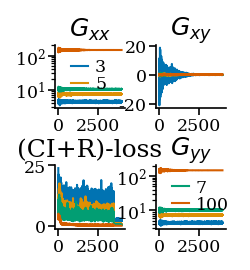

In [58]:
figsize=set_size(fraction=(1-width_ratio_hexagons,1/3),mode='square')
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=figsize)
axs[0,0].semilogy(Gss[1::3,:,0,0].T)
axs[0,0].set_title('$G_{xx}$')
axs[0,0].legend(ncells_to_include[:2])#,labelspacing=0,handlelength=1,handletextpad=0.4)
axs[0,1].plot(Gss[-2::-3,:,1,0].T)#,alpha=.7) # reverse order to plot s.t noisy is plotted first
axs[0,1].set_title('$G_{xy}$')
axs[1,0].plot(loss_histories[1::3].T)
axs[1,0].set_title('(CI+R)-loss')
artists = axs[1,1].semilogy(Gss[1::3,:,1,1].T)
axs[1,1].legend(artists[2:],ncells_to_include[2:])#,labelspacing=0)
axs[1,1].set_title('$G_{yy}$')
plt.subplots_adjust(wspace=0.45, hspace=0.9)
plt.savefig('./P3-21.png')

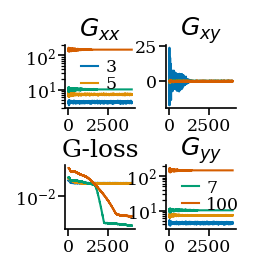

In [59]:
figsize=set_size(fraction=(1-width_ratio_hexagons,1/3),mode='square')
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=figsize)
axs[0,0].semilogy(Gss[2::3,:,0,0].T)
axs[0,0].set_title('$G_{xx}$')
axs[0,0].legend(ncells_to_include[:2])#,labelspacing=0,handlelength=1,handletextpad=0.4)
axs[0,1].plot(Gss[-3::-3,:,1,0].T)#,alpha=.7) # reverse order to plot s.t noisy is plotted first
axs[0,1].set_title('$G_{xy}$')
axs[1,0].semilogy(loss_histories[2::3].T)
axs[1,0].set_title('G-loss')
artists = axs[1,1].semilogy(Gss[2::3,:,1,1].T)
axs[1,1].legend(artists[2:],ncells_to_include[2:])#,labelspacing=0)
axs[1,1].set_title('$G_{yy}$')
plt.subplots_adjust(wspace=0.45, hspace=0.9)
plt.savefig('./P3-31.png')

In [9]:
def plot_phases_history(ax,phases_history,center,model,color):
    step=50
    N=len(phases_history)
    # wrap (only relevant) phases history
    phases_history[::step] = [model.unit_cell.wrap(phases_history[i]) for i in range(0,N,step)]
    phases_history += center
    alphas = np.linspace(0.05,0.1,N//step+1)
    [ax.scatter(*phases_history[i].T, s=.5, c='grey',alpha=alphas[i//step]) 
     for i in range(0,N,step)]
    ax.scatter(*phases_history[-1].T, c='red')
    #ax.scatter(*phases_history[0].T,c='blue')
    model.unit_cell.plot(fig,ax,center=center,color=color)

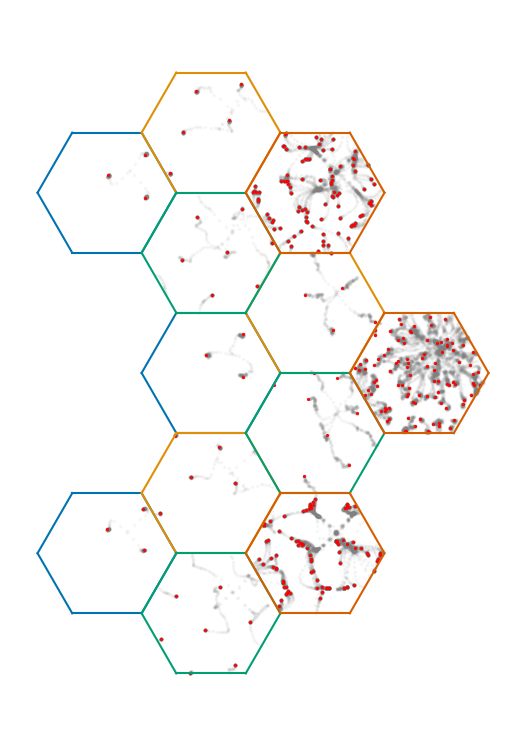

In [87]:
height_fraction_addition = (np.linalg.norm(model.unit_cell.basis[0])*2*5) / (np.linalg.norm(model.unit_cell.hpoints[0])*13/2)
#figsize=set_size(fraction=(width_ratio_hexagons,1/3),mode='square')
#figsize=set_size(fraction=(width_ratio_hexagons,height_fraction_addition/3),mode='square')
figsize=set_size(fraction=(width_ratio_hexagons,1),mode='square')
fig,ax = plt.subplots(figsize=figsize)#,dpi=250)
ax.axis('off')
ax.axis('equal')
fig.subplots_adjust(top=1,bottom=0,right=1,left=0,wspace=0,hspace=-0)
sc = model.unit_cell.center # start center
centers = np.array([sc, sc + 2*model.unit_cell.basis[1], 
                    sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]])
for i in range(len(centers)):
    center = centers[i]
    plot_phases_history(ax,phases_histories[i*3],centers[i],models[i*3],color_cycler[i])
    center += 2*model.unit_cell.basis[0] + 2*model.unit_cell.basis[-1] # down-right + down
    plot_phases_history(ax,phases_histories[i*3+1],centers[i],models[i*3+1],color_cycler[i])
    center += 2*model.unit_cell.basis[-1] + 2*model.unit_cell.basis[-2] # down + down-left
    plot_phases_history(ax,phases_histories[i*3+2],centers[i],models[i*3+2],color_cycler[i])

plt.savefig('./P3-12.png')

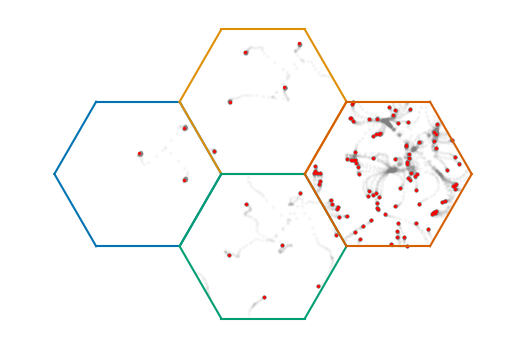

In [79]:
height_fraction_addition = (np.linalg.norm(model.unit_cell.basis[0])*2*5) / (np.linalg.norm(model.unit_cell.hpoints[0])*13/2)
#figsize=set_size(fraction=(width_ratio_hexagons,1/3),mode='square')
figsize=set_size(fraction=(width_ratio_hexagons,height_fraction_addition/3),mode='square')
fig,ax = plt.subplots(figsize=figsize)#,dpi=250)
ax.axis('off')
ax.axis('equal')
sc = model.unit_cell.center # start center
centers = [sc, sc + 2*model.unit_cell.basis[1], 
           sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]]
#for (phases_history,model,center) in zip(phases_histories[::2],models[::2],centers):
for i in range(len(centers)):
    plot_phases_history(ax,phases_histories[i*3],centers[i],models[i*3],color_cycler[i])
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,wspace=0,hspace=-0)
plt.savefig('./P3-12.png')

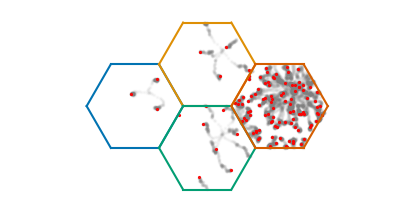

In [65]:
figsize=set_size(fraction=(width_ratio_hexagons,1/3),mode='square')
fig,ax = plt.subplots(figsize=figsize)#,dpi=250)
ax.axis('off')
ax.axis('equal')
sc = model.unit_cell.center # start center
centers = [sc, sc + 2*model.unit_cell.basis[1], 
           sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]]
#for (phases_history,model,center) in zip(phases_histories[::2],models[::2],centers):
for i in range(len(centers)):
    plot_phases_history(ax,phases_histories[i*3+1],centers[i],models[i*3+1],color_cycler[i])
plt.savefig('./P3-22.png')

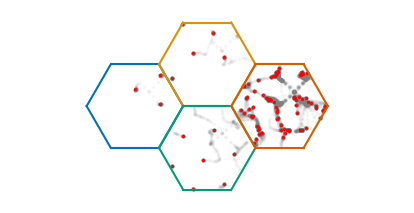

In [66]:
figsize=set_size(fraction=(width_ratio_hexagons,1/3),mode='square')
fig,ax = plt.subplots(figsize=figsize)#,dpi=250)
ax.axis('off')
ax.axis('equal')
sc = model.unit_cell.center # start center
centers = [sc, sc + 2*model.unit_cell.basis[1], 
           sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]]
#for (phases_history,model,center) in zip(phases_histories[::2],models[::2],centers):
for i in range(len(centers)):
    plot_phases_history(ax,phases_histories[i*3+2],centers[i],models[i*3+2],color_cycler[i])
plt.savefig('./P3-32.png')

# INCLUDE A METRIC PERTURBING THE PHASE-SOLUTIONS AND SHOW HOW ROBUSTNESS SCALES WITH NUMBER OF CELLS!

In [13]:
isinstance(models[0], RobustSimilitude)

True

In [14]:
def robustness(model,nsamples_space=2**8,nsamples_statistics=100,p_magnitude=1e-1,r_magnitude=1e-1):
    phases_cpy = model.phases.detach().clone()
    if not isinstance(model, RobustSimilitude):
        model = RobustSimilitude(ncells=model.ncells,rectify=model.relu)
        model.set_phases(phases_cpy)
    model.p_magnitude = p_magnitude
    model.r_magnitude = r_magnitude
    Gs = []
    loss = []
    for i in range(nsamples_statistics):
        dp, _ = RobustSimilitude.jitter(len(phases_cpy),magnitude=p_magnitude)
        model.set_phases(phases_cpy + dp)
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        G = model.metric_tensor(model.jacobian(rs)).detach().numpy()
        G_metric = np.mean(np.abs(G[:,0,0] - G[:,1,1]) + G[:,0,1] + G[:,1,0],axis=0)
        #G_metric = np.mean((G[:,0,0] - G[:,1,1])**2 + G[:,0,1]**2 + G[:,1,0]**2,axis=0)
        model.set_phases(phases_cpy)
        loss.append(model.loss_fn(rs).item())
        Gs.append(G_metric)
    return np.array(Gs), np.array(loss)

In [15]:
robustness_Gss = []
robustness_losss = []
for model in models:
    robustness_Gs, robustness_loss = robustness(model,2**8,200,p_magnitude=1e-1)#,r_magnitude=0)
    robustness_Gss.append(robustness_Gs)
    robustness_losss.append(robustness_loss)

Text(0.5, 0, '#cell')

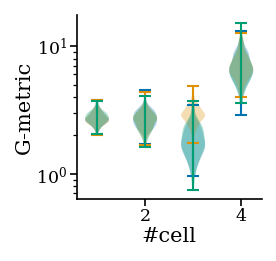

In [16]:
plt.violinplot(robustness_Gss[::3])
plt.violinplot(robustness_Gss[1::3])
plt.violinplot(robustness_Gss[2::3]);
plt.yscale('log')
plt.ylabel('G-metric')
plt.xlabel('#cell')

Text(0.5, 0, '#cell')

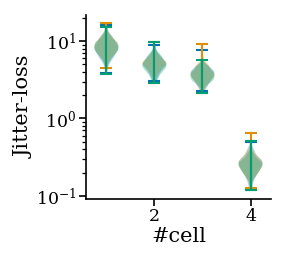

In [17]:
plt.violinplot(robustness_losss[::3])
plt.violinplot(robustness_losss[1::3])
plt.violinplot(robustness_losss[2::3])
plt.yscale('log')
plt.ylabel('Jitter-loss')
plt.xlabel('#cell')

In [18]:
# Robustness:
# 1. Wrt. #cells
# 2. Wrt. phase-solutions

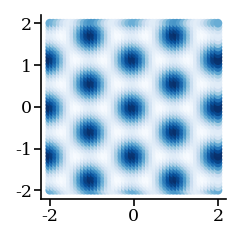

In [19]:
model = HexagonalGCs()#init_rot=10)
model.set_phases([0,0])
rs = model.unit_cell.mesh(32)
rs2 = np.mgrid[-2:2:50j,-2:2:50j].reshape(2,-1).T
a = model(torch.tensor(rs,dtype=dtype)).detach().numpy()
a2 = model(torch.tensor(rs2,dtype=dtype)).detach().numpy()
plt.scatter(*rs.T,c=a[:,0],s=10)
plt.scatter(*rs2.T,c=a2[:,0],s=10)

In [20]:
rs = model.unit_cell.mesh(300)
a = model(torch.tensor(rs,dtype=dtype)).detach().numpy()
dx = np.linalg.norm(rs[1])
tsum = np.sum(a)
print(dx, tsum)
tsum * dx**2 * np.sqrt(3) / 4

0.0038618747102985005 30133.553


0.1946020154453663

In [21]:
j.shape

NameError: name 'j' is not defined

In [ ]:
j = model.jacobian(torch.tensor(rs,dtype=dtype)).detach().numpy()
m = model.metric_tensor(j)

In [ ]:
model.unit_cell.area*2

In [ ]:
x = np.linspace(0,3,1000)
plt.plot(x,np.cos(x*2*np.pi))

In [ ]:
x2d = np.stack([x,np.zeros_like(x)],axis=-1)
plt.plot(x,model(torch.tensor(x2d,dtype=dtype)).detach().numpy())